# <center> Tree models

## Imports

In [3]:
import pandas as pd
import sklearn
import lightgbm

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import metrics
from sklearn import set_config

set_config(display='diagram')

print("Pandas  ", pd.__version__)
print("Sklearn ", sklearn.__version__)
print("LightGBM", lightgbm.__version__)

Pandas   1.1.3
Sklearn  0.23.2
LightGBM 3.1.1


## Load the data

We'll work with **data from Kickstarter projects**. The first few rows of the data looks like this:

In [4]:
df = pd.read_csv('../datasets/ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
print(len(df), "rows")
df.head(3)

378661 rows


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


## Target variable: `state`: (successful VS not successful)
The `state` column shows the outcome of the project.

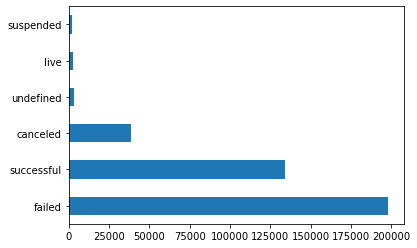

In [3]:
df.state.value_counts().plot.barh();

#### Prepare the target column

First we'll convert the `state` column into a target we can use in a model.  Data cleaning isn't the current focus, so we'll simplify this example by:

- Dropping projects that are "live"
- Counting "successful" states as `outcome = 1`
- Combining every other state as `outcome = 0`

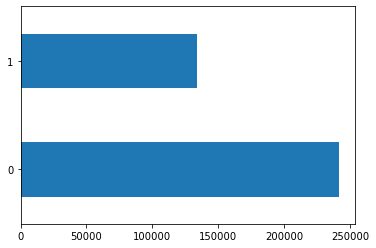

In [4]:
# Drop live projects
df = df[ df.state != "live" ]

# Add outcome column, "successful" == 1, others are 0
df["outcome"] = (df.state == 'successful').astype(int)

df.outcome.value_counts().plot.barh();

### Custom Encoders

In [7]:
from sklearn.base import TransformerMixin, BaseEstimator

class DoNothingEncoder(TransformerMixin, BaseEstimator): # 
    def __init__(self):
        pass
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        return x
    
class DateEncoder(TransformerMixin, BaseEstimator):

    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        dfs = []
        for column in df:
            dt = df[column].dt
            df_dt = pd.concat([dt.hour, dt.day, dt.month, dt.year], axis=1) # dt.weekday()
            dfs.append(df_dt)
        dfs_dt = pd.concat(dfs, axis=1)
        return dfs_dt

### Prep categorical variables

Now for the categorical variables -- `category`, `currency`, and `country` -- we'll need to convert them into integers so our model can use the data. For this we'll use scikit-learn's `OrdinalEncoder`. This assigns an integer to each value of the categorical feature.

In [8]:
date_vars = ['launched']
cat_vars  = ['category', 'currency', 'country']
num_vars  = ['goal']
target_var = 'outcome'

preprocessor = compose.ColumnTransformer(transformers=[
    ('numeric',    DoNothingEncoder(), num_vars),
    ('categories', OrdinalEncoder(),   cat_vars),
    ('date',       DateEncoder(),      date_vars),
], remainder='drop')

preprocessor

ColumnTransformer(transformers=[('numeric', DoNothingEncoder(), ['goal']),
                                ('categories', OrdinalEncoder(),
                                 ['category', 'currency', 'country']),
                                ('date', DateEncoder(), ['launched'])])

We collect all of these features in a new dataframe that we can use to train a model.

### Create training, validation, and test splits

We need to create data sets for training, validation, and testing. We'll use a fairly simple approach and split the data using slices. We'll use 10% of the data as a validation set, 10% for testing, and the other 80% for training.

In [11]:
valid_fraction = 0.1
valid_size = int(len(df) * valid_fraction)

train = df[:-2 * valid_size]
valid = df[-2 * valid_size:-valid_size]
test = df[-valid_size:]

### Train a model

For this course we'll be using a LightGBM model. This is a tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train. 

We won't do hyperparameter optimization because that isn't the goal of this course. So, our models won't be the absolute best performance you can get. But you'll still see model performance improve as we do feature engineering.

In [12]:
model = lightgbm.LGBMClassifier(
    n_estimators = 1000,
    num_leaves   = 64,
    objective    = 'binary',
    metric       = 'auc'
)

model.fit(X=preprocessor.fit_transform(train), y=train.outcome,
          eval_set=(preprocessor.transform(valid), valid.outcome),
          early_stopping_rounds=10,
          verbose=True)

[1]	valid_0's auc: 0.694192
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.697026
[3]	valid_0's auc: 0.70002
[4]	valid_0's auc: 0.701645
[5]	valid_0's auc: 0.70601
[6]	valid_0's auc: 0.707926
[7]	valid_0's auc: 0.70945
[8]	valid_0's auc: 0.710437
[9]	valid_0's auc: 0.712047
[10]	valid_0's auc: 0.713417
[11]	valid_0's auc: 0.714648
[12]	valid_0's auc: 0.715791
[13]	valid_0's auc: 0.717431
[14]	valid_0's auc: 0.718216
[15]	valid_0's auc: 0.719381
[16]	valid_0's auc: 0.720884
[17]	valid_0's auc: 0.721617
[18]	valid_0's auc: 0.722788
[19]	valid_0's auc: 0.723305
[20]	valid_0's auc: 0.724826
[21]	valid_0's auc: 0.725596
[22]	valid_0's auc: 0.727436
[23]	valid_0's auc: 0.72788
[24]	valid_0's auc: 0.728838
[25]	valid_0's auc: 0.729249
[26]	valid_0's auc: 0.730276
[27]	valid_0's auc: 0.730651
[28]	valid_0's auc: 0.731264
[29]	valid_0's auc: 0.731584
[30]	valid_0's auc: 0.732643
[31]	valid_0's auc: 0.733118
[32]	valid_0's auc: 0.733422
[33]	valid_0's auc: 0.73

LGBMClassifier(metric='auc', n_estimators=1000, num_leaves=64,
               objective='binary')

### Make predictions & evaluate the model

Finally, let's make predictions on the test set with the model and see how well it performs. An important thing to remember is that you can overfit to the validation data. This is why we need a test set that the model never sees until the final evaluation.

In [13]:
pd.DataFrame(preprocessor.fit_transform(test))

,0,1,2,3,4,5,6,7
0,3000.0,15.0,13.0,22.0,14.0,27.0,10.0,2014.0
1,2500.0,124.0,13.0,22.0,18.0,19.0,8.0,2015.0
2,750.0,105.0,5.0,9.0,19.0,29.0,9.0,2015.0
3,15000.0,91.0,13.0,22.0,18.0,23.0,10.0,2016.0
4,2000.0,137.0,1.0,3.0,3.0,8.0,3.0,2017.0
...,...,...,...,...,...,...,...,...
37581,50000.0,38.0,13.0,22.0,2.0,17.0,9.0,2014.0
37582,1500.0,92.0,13.0,22.0,3.0,22.0,6.0,2011.0
37583,15000.0,92.0,13.0,22.0,19.0,1.0,7.0,2010.0
37584,15000.0,137.0,13.0,22.0,18.0,13.0,1.0,2016.0


In [15]:
ypred = model.predict_proba(preprocessor.transform(test))[:,1]

print("Test AUC score:", metrics.roc_auc_score(test['outcome'], ypred))

Test AUC score: 0.6929708493639113


# Save End-to-end model

In [14]:
full_model = pipeline.Pipeline([('preprocessor', preprocessor), ('model', model)])
full_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', DoNothingEncoder(),
                                                  ['goal']),
                                                 ('categories',
                                                  OrdinalEncoder(),
                                                  ['category', 'currency',
                                                   'country']),
                                                 ('date', DateEncoder(),
                                                  ['launched'])])),
                ('model',
                 LGBMClassifier(metric='auc', n_estimators=1000, num_leaves=64,
                                objective='binary'))])

# Your Turn
Now you'll **[build your own baseline model](https://www.kaggle.com/kernels/fork/5407496)** which you can improve with feature engineering techniques as you go through the course.
